# Notebook on Shepp-Logan Phantom with classical regularisation techniques involving gradient descent and proximal gradient descent with L1 norm

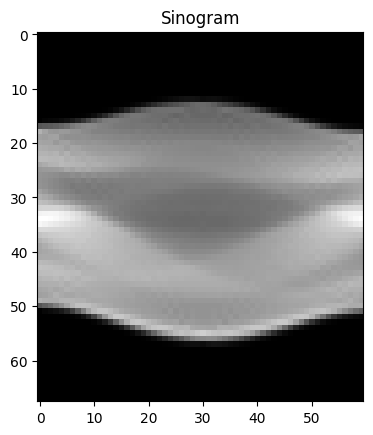

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.data import shepp_logan_phantom
from skimage.transform import resize

#numpy friendly code for the forward operator of CT etc


circle = False
n = 48
n_angles = 60
theta = np.linspace(0., 180.,n_angles, endpoint=False)

size = (radon(np.zeros((n,n)), theta=theta, circle = circle)).shape
M = size[0]*size[1]
A = np.zeros((M, n**2))
for i in range(n**2):
    e = np.zeros((n**2,))
    e[i]=1
    e = np.reshape(e,(n,n))
    sinogram = radon(e, theta=theta, circle = circle)
    A[:,i] = np.reshape(sinogram[:], (M,))

# Load the Shepp-Logan phantom
phantom = resize(shepp_logan_phantom(), (n,n))

#ground truth
x = phantom.reshape(-1)

#b
y = np.reshape(A@x, (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.title("Sinogram")
plt.imshow(y, cmap='gray')

np.float64(1792.4995672887685)

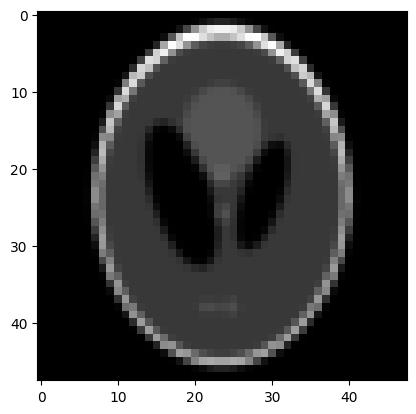

In [17]:
plt.imshow(phantom, cmap='gray')

np.linalg.cond(A)

In [18]:
x_ground_truth = x.flatten()
clean_sinogram_flattened = A@x.flatten()
sigma = 1e-1
noisy_sinogram = clean_sinogram_flattened + sigma * np.random.normal(0, 1, clean_sinogram_flattened.shape)

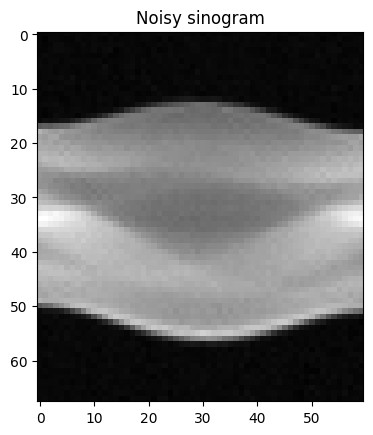

In [19]:
#noisy sinogram
plt.title("Noisy sinogram")
n_sinogram = np.reshape(noisy_sinogram, (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.imshow(n_sinogram, cmap='gray')

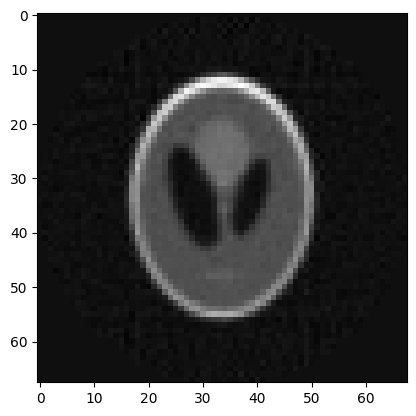

In [20]:
from skimage.transform import iradon
reconstruction_fbp = iradon(n_sinogram, theta=theta, filter_name='ramp')
plt.imshow(reconstruction_fbp, cmap='gray')

In [43]:
# plotting of results and relative error convergence
def plot_and_estimate_convergence(norm_res, method, ytitle, color='k'):
    """
    Plot the convergence of the method based on the norm of the relative error.
    """
    K = len(norm_res)

    plt.semilogy(norm_res, color=color, label=method)
    k = np.arange(K)

    plt.ylabel(ytitle)
    plt.xlabel('number of iterations: k')
    plt.title(f'Relative error convergence of {method}')
    plt.legend()
    plt.grid()

def plot_results(x_results, errors_norm, method):
    """
    Plot the results of the gradient descent.
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(x_results[-1], (n, n)), cmap='gray')
    plt.title(f"{method} Result")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plot_and_estimate_convergence(errors_norm, method, '$\\frac{\|x_k - x_{GT}\|_2}{\|x_{GT}\|_2}$', color='k')
    
    plt.tight_layout()
    plt.show()

<>:28: SyntaxWarning: invalid escape sequence '\|'
<>:28: SyntaxWarning: invalid escape sequence '\|'
C:\Users\as5057\AppData\Local\Temp\ipykernel_20236\4262840881.py:28: SyntaxWarning: invalid escape sequence '\|'
  plot_and_estimate_convergence(errors_norm, method, '$\\frac{\|x_k - x_{GT}\|_2}{\|x_{GT}\|_2}$', color='k')


# Gradient descent with no regularisation

In [39]:
#Gradient descent
# General algorithm parameters
#x_zero = np.zeros(n*n)

def gradient_descent(A, b, x0, niter, tol, x_ground_truth = x_ground_truth):
    """
    Perform gradient descent to solve Ax = b.
    
    A - forward operator
    b - noisy sinogram
    x0 - initial guess
    niter - number of iterations
    tol - tolerance for convergence
    x_ground_truth - ground truth solution for error calculation

    Returns:
    X - solution vector
    rel_errors - relative errors at each iteration
    results - intermediate results at each iteration
    """
    rel_errors = []
    results = []
    X = x0.copy()
    for k in range(niter):
        res = b - A @ X  # Compute current residual
        grad_g = A.T @ (A @ X - b)  # Gradient of the objective function
        err = np.linalg.norm(X - x_ground_truth)/(np.linalg.norm(x_ground_truth)) #Error
        #store errors and results
        rel_errors.append(err)
        results.append(X.copy())
        norm_res = np.linalg.norm(res)
        
        if np.linalg.norm(grad_g) <= tol:  # Termination criterion
            print(f'Iteration {k}: residual {norm_res:.4e} is less than tolerance {tol}\n')
            break
        
        t = (np.linalg.norm(grad_g)**2) / (np.linalg.norm(A @ grad_g)**2)
        X -= t * grad_g  # Update step
    
    return X, rel_errors, results


niter = 500
x0 = np.random.rand(n**2) # Initial value of x_0 (constraints - can ensure it is positive to make it physically representable)
tol = 1e-3 # Tolerance for termination

gradient_descent_result, errors_norm, x_results = gradient_descent(A, noisy_sinogram, x0, niter, tol)

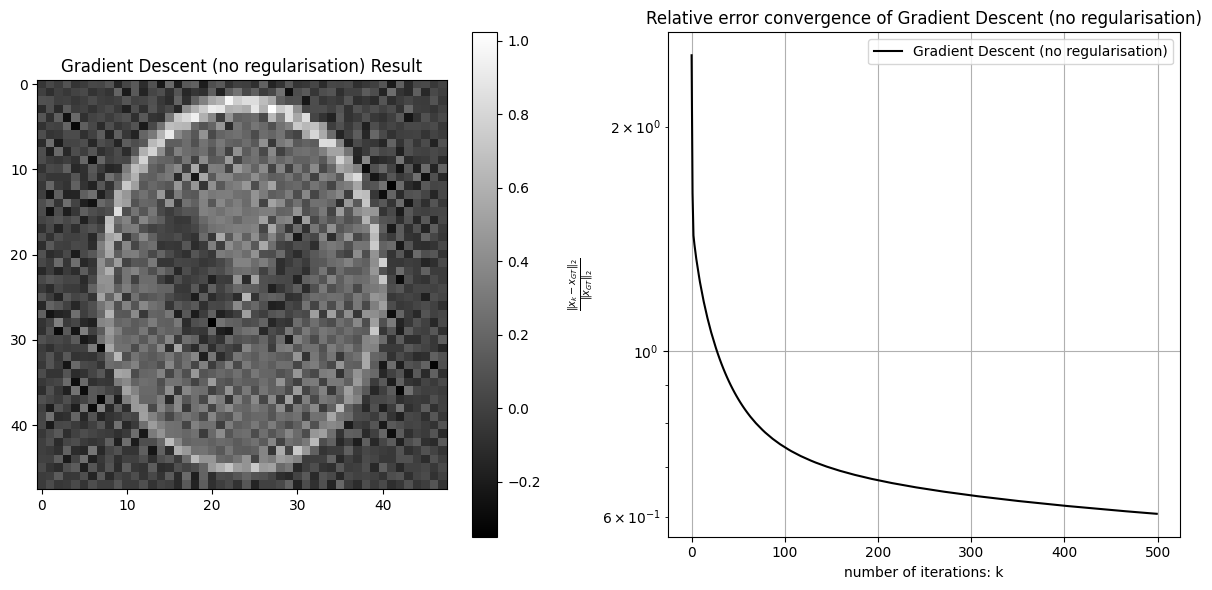

In [44]:
plot_results(x_results, errors_norm, "Gradient Descent (no regularisation)")

# Tikhonov regularisation $R(x) = \|x\|^2_2$

Iteration 164: gradient norm 9.4924e-03 is less than tolerance 0.01



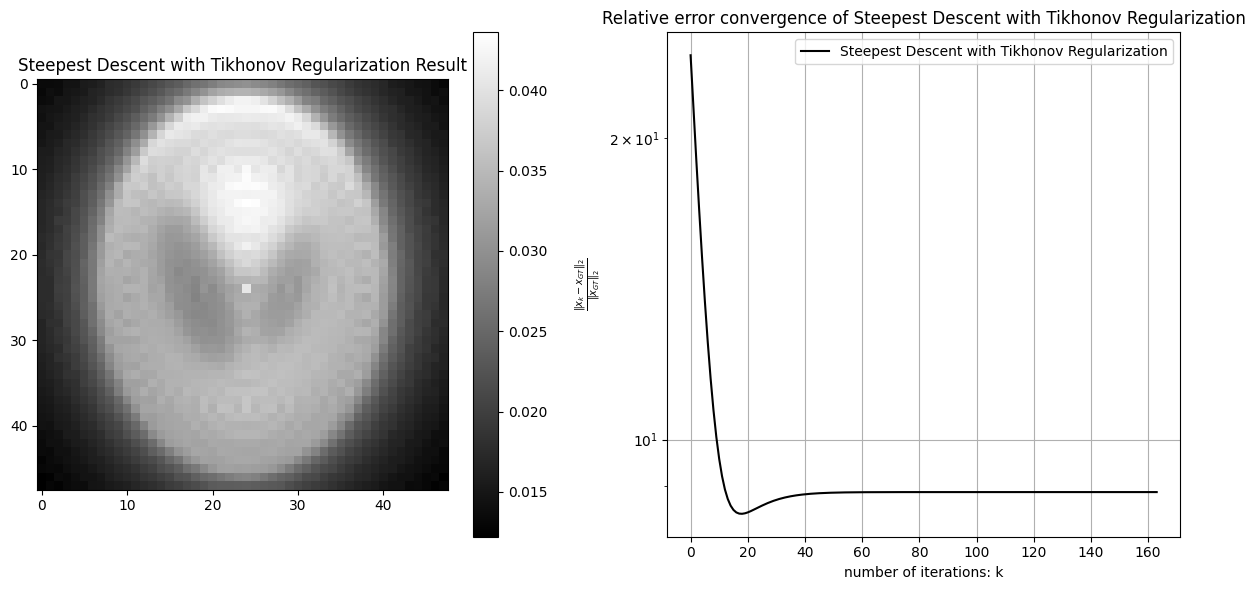

In [45]:
def steepest_descent_tikhonov(A, b, x_ground_truth, alpha, niter, tol):
    """ 
    Steepest descent method with Tikhonov regularization
    A - forward operator
    b - noisy sinogram
    x_ground_truth - ground truth solution 
    alpha - regularization parameter
    niter - number of iterations
    tol - tolerance for convergence
    """
    n_squared = A.shape[1] #n**2
    new_b = A.T @ b
    M = A.T @ A + alpha * np.eye(n_squared)
    L = np.linalg.norm(A)**2 + alpha
    tk = 1 / L  # Initial stepsize
    x0 = np.random.rand(n_squared)  # Initial value of x_0 (constraints)
    X1 = x0
    err_SD1 = []
    res_SD1 = []

    g = lambda m: 0.5 * np.linalg.norm(A @ m - b) ** 2 + alpha/2 * np.linalg.norm(m)**2
    for k in range(niter):
        current_g = g(X1)
        err1 = x_ground_truth - X1

        grad_g = A.T @ (A @ X1 - b) + alpha * X1
        norm_grad = np.linalg.norm(grad_g)

        if np.linalg.norm(grad_g) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(k, np.linalg.norm(grad_g), tol))
            break

        # Backtracking Line Search
        while True:
            X1_new = X1 - tk * grad_g
            new_g = g(X1_new)
            if new_g <= current_g - 0.001*tk*(norm_grad**2):
                break
            tk *= 0.5

        # This is only needed for plots
        res_SD1.append(current_g)  # 2-norm of residual
        err_SD1.append(np.linalg.norm(err1))  # 2-norm of error
        X1 = X1_new

    return X1, res_SD1, err_SD1

b= noisy_sinogram
X1_opt, res_SD1, err_SD1 = steepest_descent_tikhonov(A, b, x_ground_truth, 10000, 1000, 1e-2)
plot_results([X1_opt], err_SD1, "Steepest Descent with Tikhonov Regularization")
#X2_opt, res_SD2, err_SD2 = steepest_descent_tikhonov(A, b, x_ground_truth, 1000, 1000, 1e-2)
#X3_opt, res_SD3, err_SD3 = steepest_descent_tikhonov(A, b, x_ground_truth, 100, 1000, 1e-2)
#X4_opt, res_SD4, err_SD4 = steepest_descent_tikhonov(A, b, x_ground_truth, 10, 1000, 1e-2)

# L1 (iterative soft-thresholding algorithm/proximal gradient descent with $R(x) = \|x\|_1$)

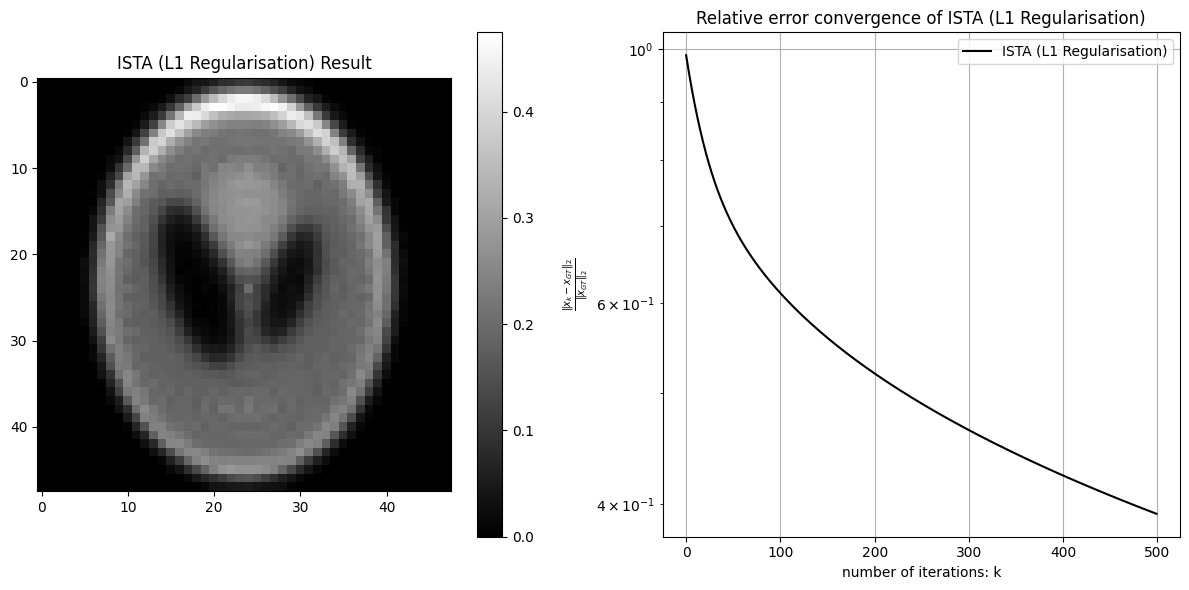

In [47]:
#ISTA
def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0.)


def ista(A, b, x_g, l, iters, tol):
    """ 
    Iterative Soft-Thresholding Algorithm (ISTA)
    A - forward operator
    b - noisy sinogram
    x_g - ground truth solution
    l - regularisation parameter
    iters - number of iterations
    tol - tolerance for convergence
    """

    x = np.zeros(A.shape[1])
    gs = []
    relative = []
    L = np.linalg.norm(A) ** 2  # Lipschitz constant
    for i in range(iters):
        grad_g = A.T @ (A @ x - b)

        #Proximal operator on L1 - soft-thresholding operator
        x = soft_thresh(x + np.dot(A.T, b - A.dot(x)) / L, l / L)
        
        #value of the objective function
        current_g = 0.5 * np.linalg.norm(A.dot(x) - b) ** 2 + l * np.linalg.norm(x, 1)
        gs.append(current_g)
        diff = np.linalg.norm(x - x_g)/np.linalg.norm(x_g)
        relative.append(diff)
        if np.linalg.norm(grad_g) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(k, np.linalg.norm(grad_g), tol))
            break
    return x, relative, gs


x_l1, rel_l1, g_l1 = ista(A, b, x_ground_truth, 50, 500, 1e-2)
plot_results([x_l1], rel_l1, "ISTA (L1 Regularisation)")